In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#generate multivariate normal sample
dim = 3
T = 300

mean = np.zeros(dim)
cov = np.eye(dim)

x = np.random.multivariate_normal(mean, cov, size=T)
df = pd.DataFrame(x)

$
\bar{z_t} = z_t - \mu
$


In [3]:
#demean the multivariate time series

def center(x):
    return x - x.mean(axis=0)

$
\hat{\Gamma_l} = \frac{1}{T-1}  \sum_{t=l+1}^{T} (z_t-\hat{\mu_z})(z_{t-l}-\hat{\mu_z})\prime
$

In [4]:
#cross-covariance matrix in Tsay notation


def cross_covariance(x, lag=0):
    T = x.shape[0]
    dim = x.shape[1]

    x_c = center(x)
    if lag > 0:
        x_t = x_c[lag:]
        x_tl = x_c[:-lag]
        summ = np.zeros([dim,dim])
        for i in range(len(x_t)):
            summ += x_t[i].reshape(dim,1).dot(x_tl[i].reshape(1,dim))
        return summ / (T-1)
    elif lag == 0:
        return np.cov(x, rowvar=False)


$
\hat{D} = diag(\hat{\gamma}^{1/2}_{0,11},...,\hat{\gamma}^{1/2}_{0,kk})
$

$
\hat{\rho_l}= \hat{D}^{-1}\hat{\Gamma_l}\hat{D}^{-1}
$

In [5]:
#cross-correlation matrix
#evaluates lagged correlations between different z_i,t and z_k,t-l

def cross_correlation(x, lag=1):
    T = x.shape[0]
    dim = x.shape[1]

    x_c = center(x)
    corr = cross_covariance(x, lag)
    gamma = np.linalg.inv(np.diag(np.sqrt(np.diagonal(cross_covariance(x,0)))))
    return gamma.dot(corr).dot(gamma)

In [9]:
#simplified matrix in Tsay notation 
#in fact, evaluates whether cross-correlation matrix for certain lag has significant coeffs
#the output is adjustable

def simplified_matrix(x, lag=0):
    ccm = cross_covariance(x,lag)
    time = x.shape[0]
    syms = ['+','-','.']
    
    s = np.empty(0)
    for i in ccm.flatten():
        if i >= 2/np.sqrt(time):
            s = np.append(s, syms[0])
        elif i <= -2/np.sqrt(time):
            s = np.append(s, syms[1])
        else:
            s = np.append(s, syms[2])
    return s.reshape(ccm.shape)
    

In [21]:
def plotter(x, lags=10):
    time = x.shape[0]
    ci = 2/np.sqrt(time)
    dim = x.shape[1]
    
    collect = np.zeros(0)
    for lag in np.arange(lags):
        collect = np.append(collect, cross_correlation(x,lag).flatten())
        
    collect = collect.reshape(lags,dim,dim)    
    fig, axs = plt.subplots(dim,dim,figsize=(4*dim,3*dim))
    for i in range(dim):
        for j in range(dim):
            N = len(collect[:,i,j])
            axs[i,j].axhline(0, color='black')
            axs[i,j].axhline(ci, color='red', linestyle='--',linewidth=0.5)        
            axs[i,j].axhline(-ci, color='red', linestyle='--',linewidth=0.5)

            axs[i,j].plot(collect[:,i,j], '.', color='b',linewidth=0.5)
            axs[i,j].vlines(np.arange(N), np.zeros(N), collect[:,i,j], color='b', alpha=0.5)
            axs[i,j].set_ylim(-1.1,1.1)


In [17]:
dim = 5
T = 500

mean = np.random.random(5)
cov = np.random.random((5,5))
cov = cov.T.dot(cov)

x = np.random.multivariate_normal(mean, cov, size=T)

In [19]:
mean, cov

(array([0.78056139, 0.37271157, 0.68862557, 0.99665745, 0.6708584 ]),
 array([[1.54187171, 0.76418867, 1.65519158, 1.61549366, 1.29871456],
        [0.76418867, 0.90138365, 0.72722249, 0.4006715 , 0.58132287],
        [1.65519158, 0.72722249, 1.79452189, 1.79620924, 1.40991949],
        [1.61549366, 0.4006715 , 1.79620924, 2.50526433, 1.65280594],
        [1.29871456, 0.58132287, 1.40991949, 1.65280594, 1.43480329]]))

In [23]:
cross_covariance(x, lag=0)

array([[1.64849825, 0.88083493, 1.7558493 , 1.65975923, 1.32050357],
       [0.88083493, 1.00169171, 0.84278167, 0.48085504, 0.63214305],
       [1.7558493 , 0.84278167, 1.88843151, 1.83117259, 1.42411162],
       [1.65975923, 0.48085504, 1.83117259, 2.42614961, 1.600943  ],
       [1.32050357, 0.63214305, 1.42411162, 1.600943  , 1.38576306]])

In [30]:
cross_correlation(x, lag=3)

array([[-0.00973502, -0.01594919, -0.01083742, -0.02872008, -0.05719613],
       [-0.0186764 , -0.04828558, -0.01547687, -0.0027805 , -0.03196404],
       [-0.00954788, -0.01244609, -0.01110804, -0.03157911, -0.05957985],
       [ 0.00502408,  0.00986982,  0.00274368, -0.04866478, -0.06180268],
       [-0.01667048, -0.02907408, -0.0166605 , -0.04314775, -0.0816572 ]])

In [29]:
simplified_matrix(x, lag=3)

array([['.', '.', '.', '.', '.'],
       ['.', '.', '.', '.', '.'],
       ['.', '.', '.', '.', '-'],
       ['.', '.', '.', '-', '-'],
       ['.', '.', '.', '.', '-']], dtype='<U32')

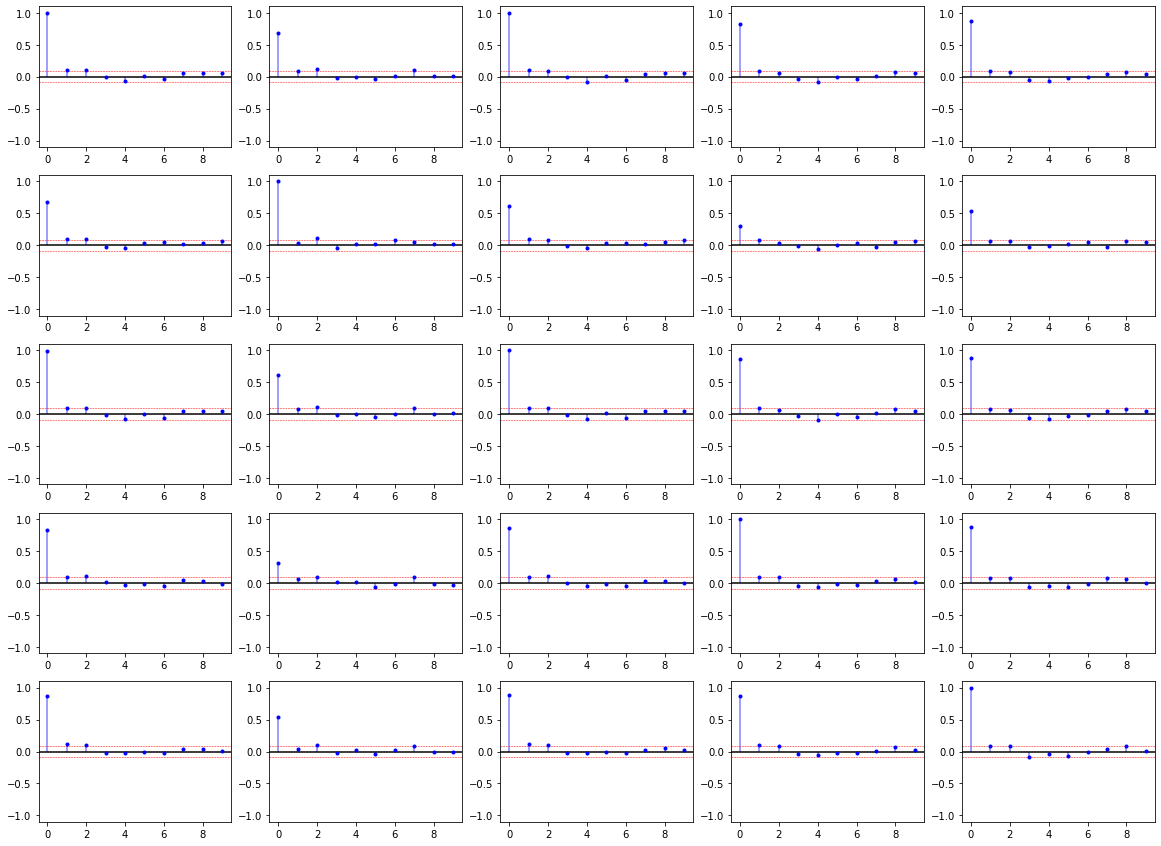

In [22]:
plotter(x)